# LightGBM Locally

To get started, we will prototype the workflow locally.

**Warning:** this notebook may fail if your local machine does not have sufficient resources. 

## Install requirements

Install required packages.

In [1]:
!pip install --upgrade dask==2.30.0 distributed==2.30.0 fastparquet adlfs lightgbm dask-lightgbm pandas

  Using cached dask_lightgbm-0.1.0-py3-none-any.whl (5.6 kB)
  Using cached lightgbm-2.3.1-py2.py3-none-macosx_10_9_x86_64.macosx_10_10_x86_64.macosx_10_11_x86_64.macosx_10_12_x86_64.macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl (679 kB)
  Using cached toolz-0.10.0-py3-none-any.whl
  Attempting uninstall: toolz
    Found existing installation: toolz 0.11.1
    Uninstalling toolz-0.11.1:
      Successfully uninstalled toolz-0.11.1
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.1.0
    Uninstalling lightgbm-3.1.0:
      Successfully uninstalled lightgbm-3.1.0
You should consider upgrading via the '/Users/cody/miniconda3/envs/dkdc/bin/python -m pip install --upgrade pip' command.


## Get Data

The data is modified from a kaggle competition and hosted publicly.

start a distributed Client

In [2]:
from distributed import Client

c = Client()
c

Client Scheduler: tcp://127.0.0.1:64437 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 68.72 GB


initialize the Pythonic filesystem

**Tip:** if you're not using public data, you need to provide data credentials. These can be retrieved through Azure ML Datastores, e.g.:

```python
from azureml.core import Workspace

ws = Workspace.from_config()
ds = ws.get_default_datastore() # ws.datastores["my-datastore-name"]

storage_options = {
    "account_name": ds.account_name,
    "account_key": ds.account_key
}
```

In [3]:
from adlfs import AzureBlobFileSystem

container_name = "malware"
storage_options = {"account_name": "azuremlexamples"}

fs = AzureBlobFileSystem(**storage_options)
fs

list the processed (partitioned) files

In [4]:
files = fs.ls(f"{container_name}/processed")
files

['malware/processed/test.parquet/', 'malware/processed/train.parquet/']

read data into a (dask) dataframe

In [5]:
import pandas as pd
import dask.dataframe as dd

for f in files:
    if "train" in f:
        df_train = dd.read_parquet(f"az://{f}", storage_options=storage_options)
    elif "test" in f:
        df_test = dd.read_parquet(f"az://{f}", storage_options=storage_options)

df_train

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
npartitions=256,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,object,object,object,object,int64,float64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,object,object,object,int64,int64,object,object,object,float64,int64,object,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,object,float64,object,float64,int64,float64,object,float64,float64,float64,object,object,float64,object,object,object,int64,int64,object,object,object,float64,int64,object,int64,object,object,float64,float64,object,float64,float64,float64,int64,float64,float64,int64,int64,float64,float64,float64,int64
0101cfc3cc3970c26713608ee57e62e1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff004763ecb08ea8d52833ae10e475da,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffff75ba4f33d938ccfdb148b8ea16,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Exploratory Data Analysis (EDA)

Explore the data - for the purpose of this tutorial, we will simply print out a sample of the train and test dataframes and compute other basic descriptions.

In [6]:
df_train.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [7]:
df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,
0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,...,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0
00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,...,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0
0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,...,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0
0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,...,628.0,26320.0,1,0.0,0.0,0,0,0.0,0.0,10.0
00000574cefffeca83ec8adf9285b2bf,win8defender,1.1.15400.4,4.18.1809.2,1.279.236.0,0,7.0,0,NaN,53447.0,1.0,...,556.0,63269.0,1,NaN,0.0,0,0,0.0,1.0,3.0


In [8]:
%%time
df_train.describe().compute()

CPU times: user 1min 4s, sys: 3.29 s, total: 1min 8s
Wall time: 2min 55s


,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8.921483e+06,8.889165e+06,8.921483e+06,433438.000000,8.885262e+06,8.885262e+06,8.885262e+06,8.921483e+06,8.921483e+06,8.596074e+06,...,8.761350e+06,8.921483e+06,3.261780e+06,8.905530e+06,8.921483e+06,8.921483e+06,8.850140e+06,8.618032e+06,8.618032e+06,8.921483e+06
mean,7.509962e-06,6.845332e+00,1.733378e-02,1658.355421,4.784001e+04,1.326779e+00,1.020967e+00,9.879711e-01,1.080490e+02,8.126653e+04,...,3.302792e+04,4.860229e-01,3.065811e-07,7.039446e-03,1.255431e-01,3.807091e-02,5.741920e-02,2.835785e-01,7.883565e+00,4.997927e-01
std,2.740421e-03,1.026055e+00,1.305118e-01,998.960373,1.403237e+04,5.229272e-01,1.675544e-01,1.090149e-01,6.304706e+01,4.892339e+04,...,2.120691e+04,4.998046e-01,5.536976e-04,8.360558e-02,3.313338e-01,1.913675e-01,2.326419e-01,4.507347e-01,4.550121e+00,5.000000e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,...,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,0.000000e+00,1078.000000,4.948000e+04,1.000000e+00,1.000000e+00,1.000000e+00,5.100000e+01,3.737600e+04,...,1.329900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,7.000000e+00,0.000000e+00,1727.000000,5.344700e+04,1.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,8.290400e+04,...,3.307500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00
75%,0.000000e+00,7.000000e+00,0.000000e+00,2434.000000,5.344700e+04,2.000000e+00,1.000000e+00,1.000000e+00,1.640000e+02,1.247360e+05,...,5.259800e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00
max,1.000000e+00,3.500000e+01,1.000000e+00,3213.000000,7.050700e+04,7.000000e+00,5.000000e+00,1.000000e+00,2.220000e+02,1.679620e+05,...,7.210500e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01,1.000000e+00


CPU times: user 9.21 s, sys: 1.42 s, total: 10.6 s
Wall time: 1min 50s


<AxesSubplot:>

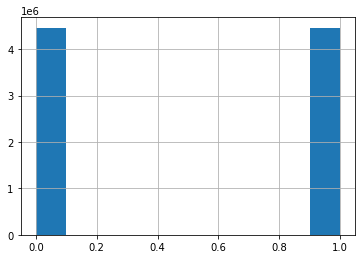

In [9]:
%%time
df_train["HasDetections"].compute().hist()

## Data Preparation

Prepare data for ML - for the purpose of this tutorial, we will simply ignore non-numeric columns.

In [10]:
cols = [col for col in df_train.columns if df_train.dtypes[col] != "object"]
cols

['IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifi

In [11]:
X = df_train[cols].drop("HasDetections", axis=1).values.persist()
X

dask.array<values, shape=(nan, 52), dtype=float64, chunksize=(nan, 52), chunktype=numpy.ndarray>

In [12]:
y = df_train["HasDetections"].persist()
y

Dask Series Structure:
npartitions=256
0000028988387b115f69f31a3bf04f09    int64
0101cfc3cc3970c26713608ee57e62e1      ...
                                    ...  
ff004763ecb08ea8d52833ae10e475da      ...
ffffff75ba4f33d938ccfdb148b8ea16      ...
Name: HasDetections, dtype: int64
Dask Name: getitem, 256 tasks

## Train LightGBM

Now, we can use the ``lightgbm.dask`` module for distributed XGBoost training through Python.

In [23]:
from dask_lightgbm import LGBMRegressor

In [24]:
params = {
    "objective": "binary",
    "boosting": "gbdt",
    "num_iterations": 2,
    "learning_rate": 0.1,
    "num_leaves": 31,
}

In [25]:
LGBMRegressor?

Init signature:
LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,
    silent=True,
    importance_type='split',
    **kwargs,
)
Docstring:      LightGBM regressor.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : string, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropouts meet Multiple Additive Regression Trees.
    'goss', Gradient-based One-Side Sampling.
    'rf', Random Forest.
num_leaves : int, optional (default=31)
    Maximum tree leaves for base learners.
max_depth : int, optional (default=-1)
    Maximum tree depth for bas

In [26]:
%%time
model = LGBMRegressor(**params)
model.fit(X, y)

Parameter tree_learner not set or set to incorrect value (None), using "data" as default
distributed.nanny - WARNING - Restarting worker


KeyError: 'tcp://127.0.0.1:50552'

## Save model

Optionally, save the model.

In [ ]:
model

In [ ]:
model["booster"].save_model("xgboost.model")